In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

import Pyro4.util

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240617


In [5]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


Load config

In [6]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Mon Jul 24 13:57:32 2023):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.08

In [11]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

Default Instrument SC_26C1


0

# Functions for fine calibration experiments

In [49]:
def run_length_rabi(qZZ, qTest, yaml_cfg, checkEF=False, test_pi_half=False, divide_len=True, save_data=True):
    assert qZZ != qTest
    print(f"-------- length rabi --------")
    lengthrabiZZ = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_ZZ_qubit{qZZ}{qTest}",
        config_file=config_path,
    )
    lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    lengthrabiZZ.cfg.expt = dict(
        start=0, # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        expts=101,
        reps=1000,
        pulse_type='gauss',
        checkEF=checkEF, 
        qTest=qTest,
        qZZ=qZZ,
        test_pi_half=test_pi_half,
        divide_len=divide_len,
    )

    try:
        lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    lengthrabiZZ.analyze(fit=True)
    
    lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
    lengthrabiZZ.display(fit=True)
    p = lengthrabi_fit
    if p[2] > 180: p[2] = p[2] - 360
    elif p[2] < -180: p[2] = p[2] + 360
    if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
    else: pi_len = (3/2 - p[2]/180)/2/p[1]
    pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

    if save_data: lengthrabiZZ.save_data()

    return pi_len

In [50]:
def run_amp_rabi(qZZ, qTest, yaml_cfg, checkEF=False, test_pi_half=False, divide_len=True, save_data=True):
    print(f"-------- Amp rabi --------")

    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{qZZ}{qTest}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    old_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qTest, qZZ]
    if checkEF: old_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qTest, qZZ]

    if old_gain == 0:
        old_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qTest, qTest]
        if checkEF: old_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qTest, qTest]
    
    if test_pi_half and not divide_len: old_gain = old_gain // 2

    span = min((32000, 1.5*old_gain))
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=100,
        rounds=10,
        pulse_type='gauss',
        checkEF=checkEF, 
        qTest=qTest,
        qZZ=qZZ,
        test_pi_half=test_pi_half,
        divide_len=divide_len,
    )

    try:
        amprabi.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    amprabi.analyze(fit=True)

    amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

    p = amprabi_fit
    if p[2] > 180: p[2] = p[2] - 360
    elif p[2] < -180: p[2] = p[2] + 360
    if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
    else: pi_gain = (3/2 - p[2]/180)/2/p[1]

    if pi_gain > 32000:
        amprabi.display(fit=False)
        print('WARNING: Fit pi pulse gain is long, please double check!')
        pi_gain = 30000
    else: amprabi.display(fit=True)

    if save_data: amprabi.save_data()

    return int(pi_gain)

In [51]:
def run_ramsey(qZZ, qTest, yaml_cfg, checkEF=False, save_data=True):

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qTest}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=2.5, # [MHz]
        reps=100,
        rounds=10,
        checkEF=checkEF, 
        qTest=qTest,
        qZZ=qZZ,
    )
    
    ramsey.go(analyze=False, display=False, progress=True, save=False)
    ramsey.analyze(fit=True)

    ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

    ramsey.display(fit=True)

    if save_data: ramsey.save_data()

    if checkEF: return np.reshape(ramsey.cfg.device.qubit.f_ef, (4,4))[qTest, qZZ] + ramsey_adjust[0]
    else: return np.reshape(ramsey.cfg.device.qubit.f_ge, (4,4))[qTest, qZZ] + ramsey_adjust[0]


In [52]:
def run_error_amp(qZZ, qTest, yaml_cfg, checkEF=False, test_pi_half=False, divide_len=True, save_data=True):

    print(f"-------- Error amplification --------")

    npulsecalib = meas.NPulseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptQ{qZZ}{qTest}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
    npulsecalib.cfg.expt = dict(
        start=0, # number gate repetitions
        step=1,
        expts=10,
        reps=1000,
        loops=20,
        pulse_type='gauss',
        test_pi_half=test_pi_half,
        divide_len=divide_len,
        error_amp=True,

        checkEF=checkEF, 
        qTest=qTest,
        qZZ=qZZ,

        post_process='scale',
        singleshot_reps=15000,
    )

    # print(npulsecalib.cfg)
    import Pyro4.util
    try:
        npulsecalib.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))


    # temp_data, attrs = prev_data(expt_path, f'00000_NPulseExptQ{qZZ}{qTest}.h5')
    # npulsecalib.cfg = AttrDict(attrs['config'])
    # npulsecalib.data = temp_data

    data = npulsecalib.data

    npulsecalib.analyze(fit=True)
    npulsecalib.display(fit=True)
    
    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data)
    
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - angle_err) / 180
    if test_pi_half: amp_ratio = (90 - angle_err) / 90

    old_gain = npulsecalib.cfg.expt.gain
    pi_gain = old_gain / amp_ratio

    if save_data: npulsecalib.save_data()

    return int(round(pi_gain))

# GE with ZZ shifts

### Pulse probe for 4x4 frequencies

In [ ]:
for qTest in range(4): # qubit to measure
    for qZZ in range(4): # qubit to pulse to e
    # for qZZ in range(2): # qubit to pulse to e
        # if qTest != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        # if qTest != 1 and qZZ != 1: continue
        # if qTest == 1 or qZZ == 1: continue
        # if qTest == 0 and qZZ == 1: continue
        if qZZ == qTest: continue
        print('qTest', qTest, 'qZZ', qZZ)

        qZZspec = meas.PulseProbeSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_spectroscopy_qubit{qTest}{qZZ}",
            config_file=config_path,
        )
        
        span = 20
        npts = 251
        
        qZZspec.cfg.expt = dict(
            start=np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))[qTest, qTest]-span/2, # [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=8, # Number of start to finish sweeps to average over
            length=1.0, # qubit 0 probe constant pulse length [us]
            gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qTest, qTest]/80), # Qubit pulse gain
            pulse_type='gauss',
            qTest=qTest,
            qZZ=qZZ,
            checkEF=False,
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qTest} due to Q{qZZ} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)

        yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
        yaml_cfg.device.qubit.f_ge[qTest, qZZ] = qZZspec_fit[2]

        print(f'Fit Q{qTest} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qTest} shift due to Q{qZZ} in e [MHz]: {yaml_cfg.device.qubit.f_ge[qTest, qZZ] - yaml_cfg.device.qubit.f_ge[qTest, qTest]}')

        yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()

Optional: update manual config now, or just keep running the T2R calibration cell using the already updated yaml_cfg variable

In [59]:
ZZshifts = np.zeros((4,4))
reshaped_f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
for row in range(4):
    ZZshifts[row,:] = reshaped_f_ge[row,:] - reshaped_f_ge[row,row]
print('ZZs:')
print(ZZshifts)
# print(ZZshifts.flatten().tolist())

print()
print(f'New f_ge\n', np.reshape(yaml_cfg.device.qubit.f_ge, (4,4)))

print()
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_ge:')
print(yaml_cfg.device.qubit.f_ge)


ZZs:
[[ 0.         -5.3894314  -0.22967106 -0.49452499]
 [-5.37982358  0.         -1.10079771 -1.32489942]
 [-0.13461381 -1.1035285   0.         -0.52353906]
 [-0.51210812 -1.3140401  -0.53692257  0.        ]]

New f_ge
 [[4110.42824795 4105.03881655 4110.19857689 4109.93372296]
 [3442.84363981 3448.22346339 3447.12266568 3446.89856397]
 [4762.06695851 4761.09804382 4762.20157232 4761.67803326]
 [4381.16743618 4380.3655042  4381.14262173 4381.6795443 ]]

UPDATE MANUALLY IN CONFIG:
f_ge:
[4110.428247950795, 4105.038816552946, 4110.198576889643, 4109.933722963169, 3442.8436398119666, 3448.2234633901926, 3447.122665677232, 3446.8985639748066, 4762.066958508102, 4761.098043820929, 4762.201572322125, 4761.678033261405, 4381.167436176662, 4380.365504198304, 4381.142621732222, 4381.679544300405]


## Run the experiment loop

In [9]:
save_data = False
saved_files = []

In [10]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [11]:
results = dict(
    pi_ge_gain = [0]*16,
    pi_ge_sigma = [0]*16,
    f_ge = [0]*16,
)

In [13]:
do_length_rabi = do_amp_rabi = do_ramsey = do_amp_rabi_2 = do_error_amp = False

# do_amp_rabi = True
do_ramsey = True
do_amp_rabi_2 = True
do_error_amp = True

# put an override=True flag to force skipping certain qubits

######### BEGINNING QUBIT 2 WITH ZZ FROM 0 #########
initial pi_len 0.015
initial pi_gain 0
initial pi_freq 4762.066958508102
-------- Ramsey --------
Running Ramsey on Q2 with ZZ Q0


  0%|          | 0/10 [00:00<?, ?it/s]

best 2 0.020049488986852104
Current pi pulse frequency: 4762.066958508102
Fit frequency from amps [MHz]: 2.506579201342009 +/- 0.0012741754688203762
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4762.06037930676
 	4757.06037930676
T2 Ramsey from fit amps [us]: 9.948426135453577 +/- 0.771913085694826
Current pi pulse frequency: 4762.066958508102
Fit frequency from I [MHz]: 2.5072768401011656 +/- 0.0012414072071414144
Suggested new pi pulse frequency from fit I [MHz]:
 	4762.059681668001
 	4757.059681668001
T2 Ramsey from fit I [us]: 9.501944532963272 +/- 0.6863585388540296
Fit frequency from Q [MHz]: 2.5062532885554147 +/- 0.0012453104385306626
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4762.060705219546
 	4757.060705219546
T2 Ramsey from fit Q [us]: 9.827787763161437 +/- 0.7361057573886379


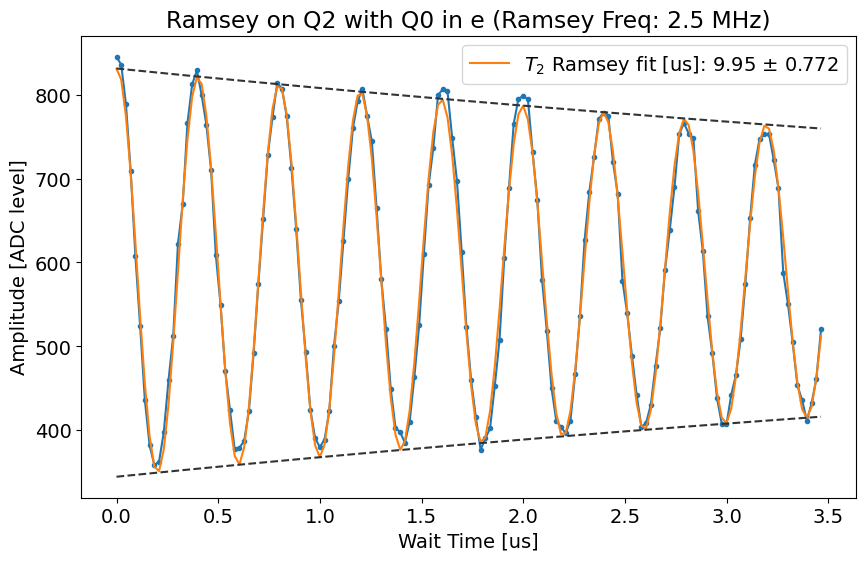

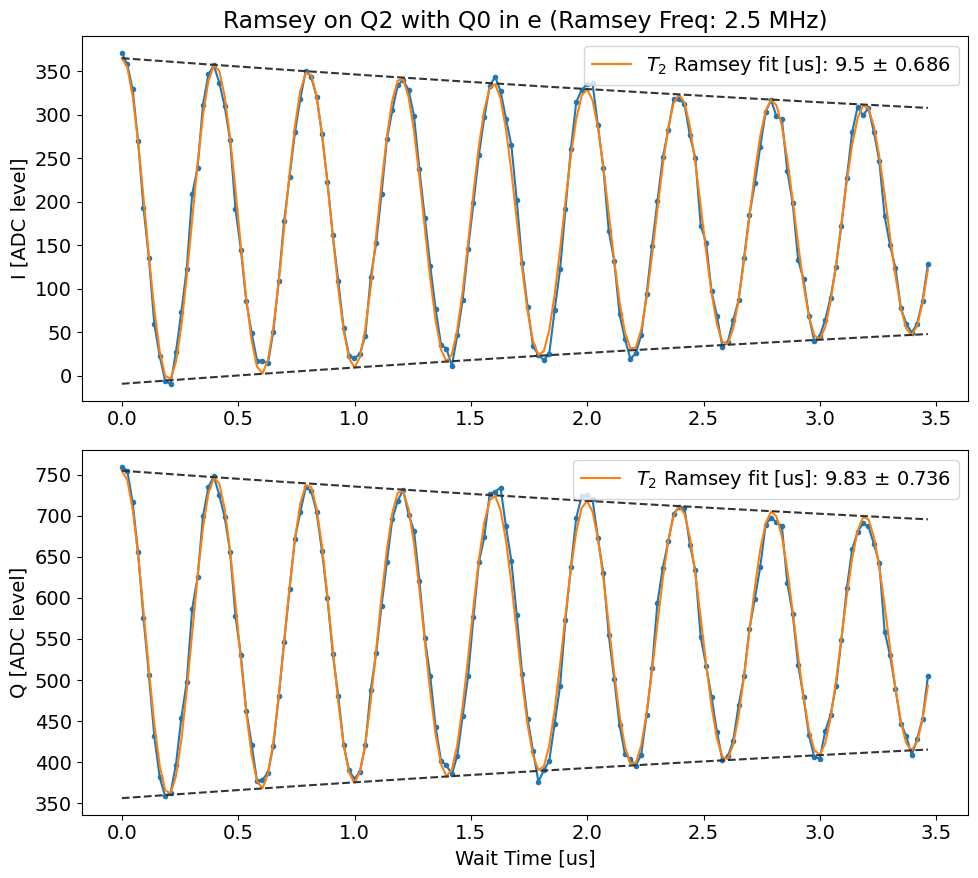

updated pi_freq 4762.060705219546
-------- Amp rabi --------
Running amp rabi on Q2 with ZZ Q0


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.004509928221652235
Pi gain from amps data [dac units]: 14498
	Pi/2 gain from amps data [dac units]: 7249
Pi gain from avgi data [dac units]: 14501
	Pi/2 gain from avgi data [dac units]: 7250
Pi gain from avgq data [dac units]: 14511
	Pi/2 gain from avgq data [dac units]: 7255


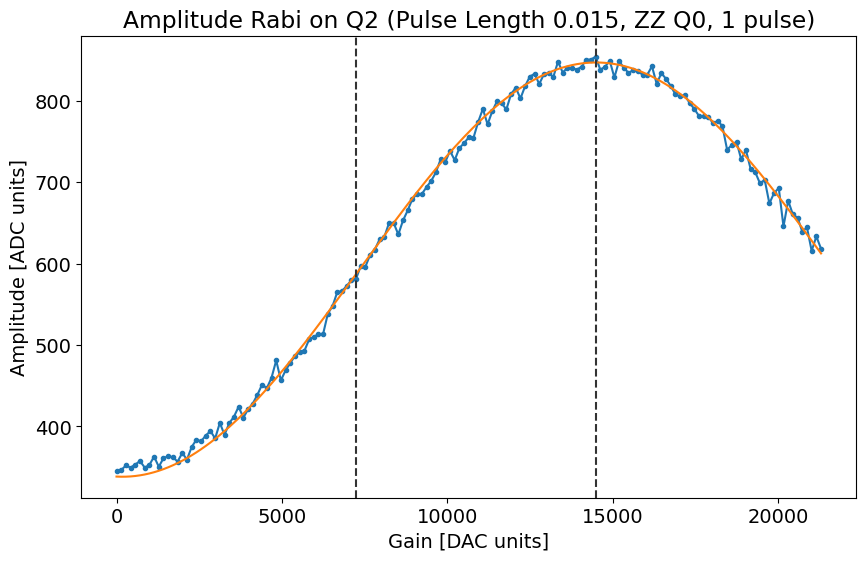

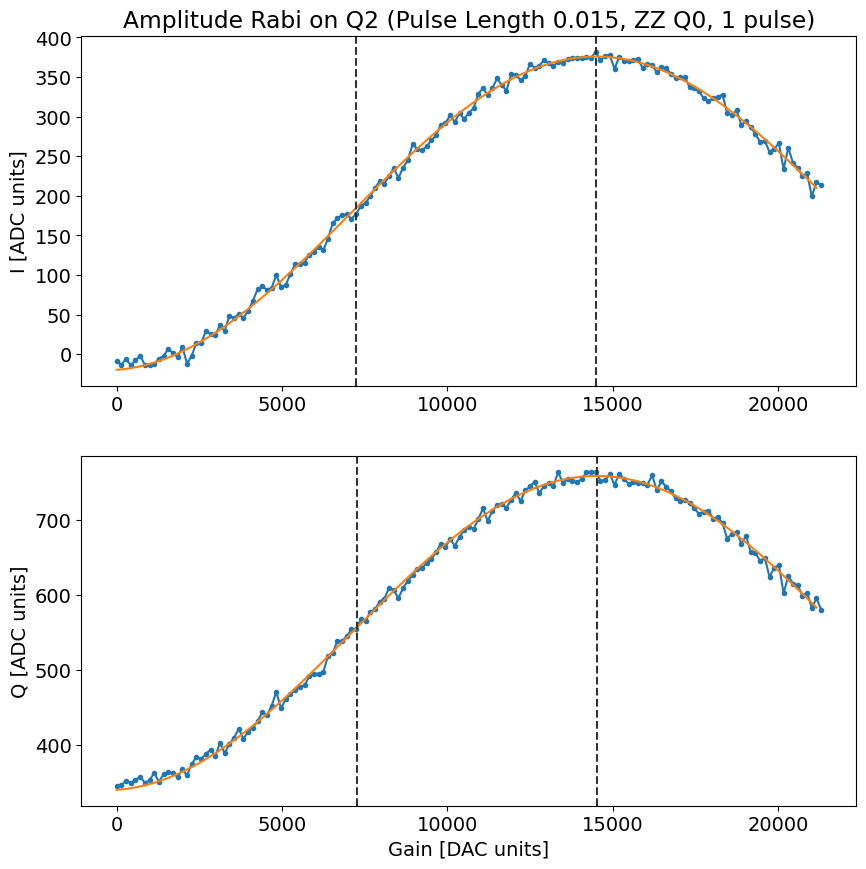

updated pi_gain round 2 14498
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (2)
ge fidelity (%): 86.34287809593653 	 angle (deg): -47.88104373407 	 threshold ge: 495.8970140123123


  0%|          | 0/20 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py:384: RuntimeWarning: divide by zero encountered in divide
  avgi_rot /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]
s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py:385: RuntimeWarning: divide by zero encountered in divide
  avgi_err /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]


fitparams [None, 0.017453292519943295]
From amps: adjust amplitude to 14498 / 1.000619051754957 = 14489.030540216454


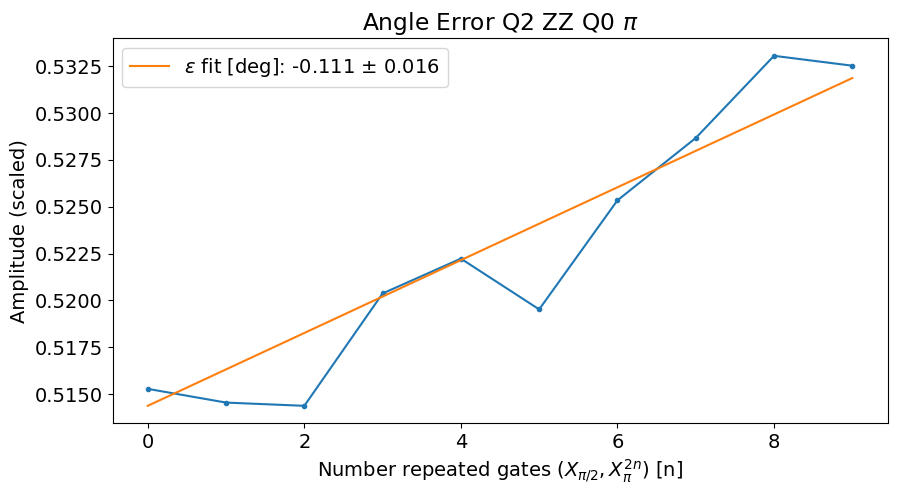

From avgi: adjust amplitude to 14498 / 1.0006194404314501 = 14489.024912157121

From avgq: adjust amplitude to 14498 / 1.0000010618096042 = 14497.984605900703


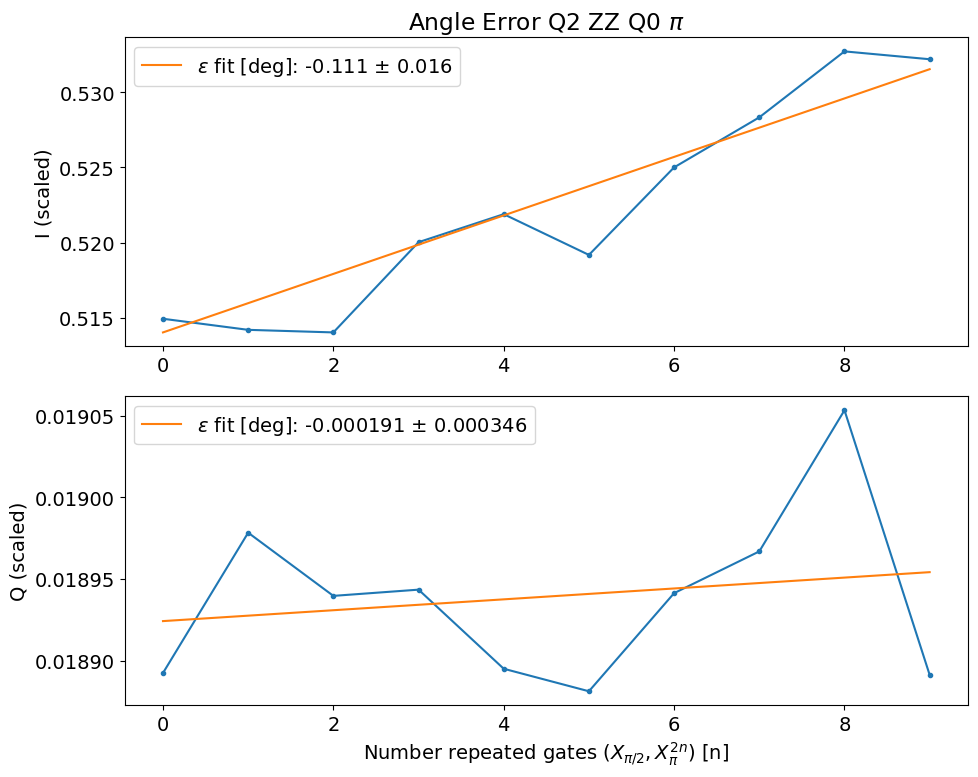

best 1 0.0730958393588555
updated pi_gain from error amplification 14489



######### BEGINNING QUBIT 3 WITH ZZ FROM 0 #########
initial pi_len 0.025
initial pi_gain 0
initial pi_freq 4381.167436176662
-------- Ramsey --------
Running Ramsey on Q3 with ZZ Q0


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.0353048820024071
Current pi pulse frequency: 4381.167436176662
Fit frequency from amps [MHz]: 2.524043518481861 +/- 0.001960526491640717
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4381.14339265818
 	4376.14339265818
T2 Ramsey from fit amps [us]: 19.0961367906231 +/- 4.420625008817506
Current pi pulse frequency: 4381.167436176662
Fit frequency from I [MHz]: 2.5219096087934583 +/- 0.0014714722239304139
Suggested new pi pulse frequency from fit I [MHz]:
 	4381.145526567869
 	4376.145526567869
T2 Ramsey from fit I [us]: 16.09403614849322 +/- 2.3548283995459673
Fit frequency from Q [MHz]: 2.523608020272538 +/- 0.0013889687969523407
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4381.14382815639
 	4376.14382815639
T2 Ramsey from fit Q [us]: 18.37365510826263 +/- 2.8987617863050046


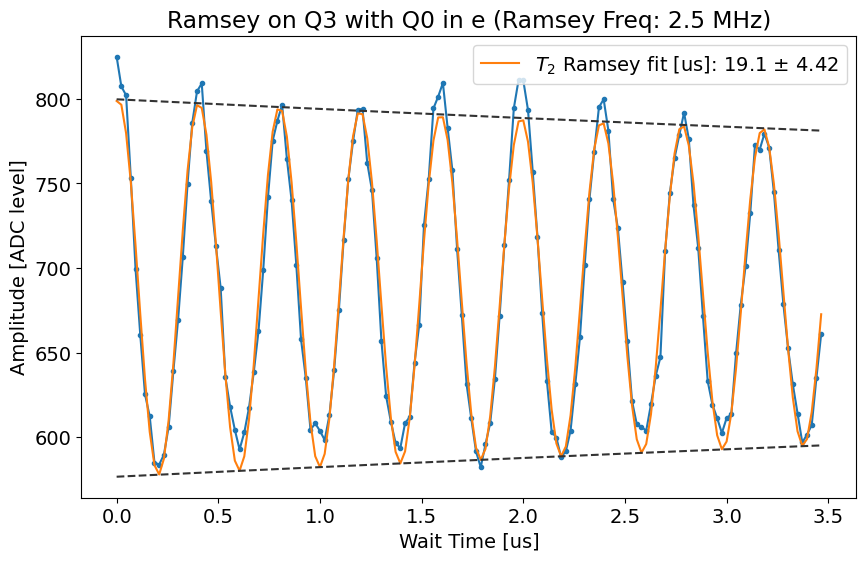

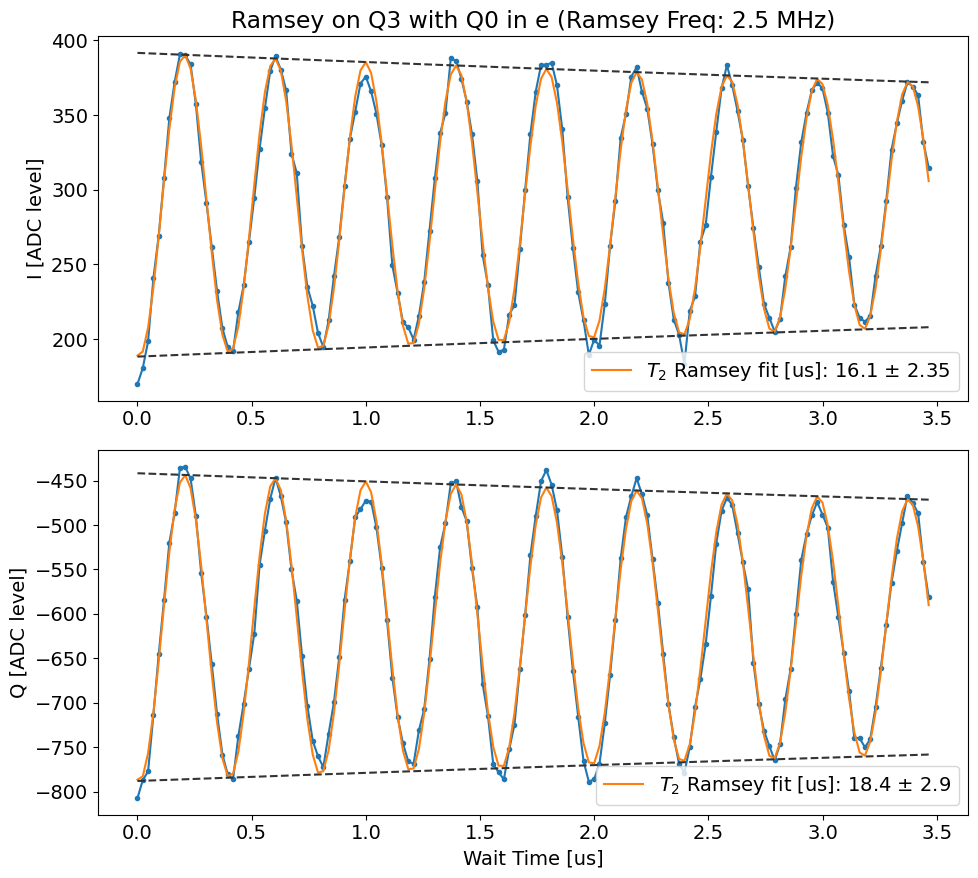

updated pi_freq 4381.145526567869
-------- Amp rabi --------
Running amp rabi on Q3 with ZZ Q0


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.011936925804050834
Pi gain from amps data [dac units]: 959
	Pi/2 gain from amps data [dac units]: 479
Pi gain from avgi data [dac units]: 963
	Pi/2 gain from avgi data [dac units]: 481
Pi gain from avgq data [dac units]: 964
	Pi/2 gain from avgq data [dac units]: 482


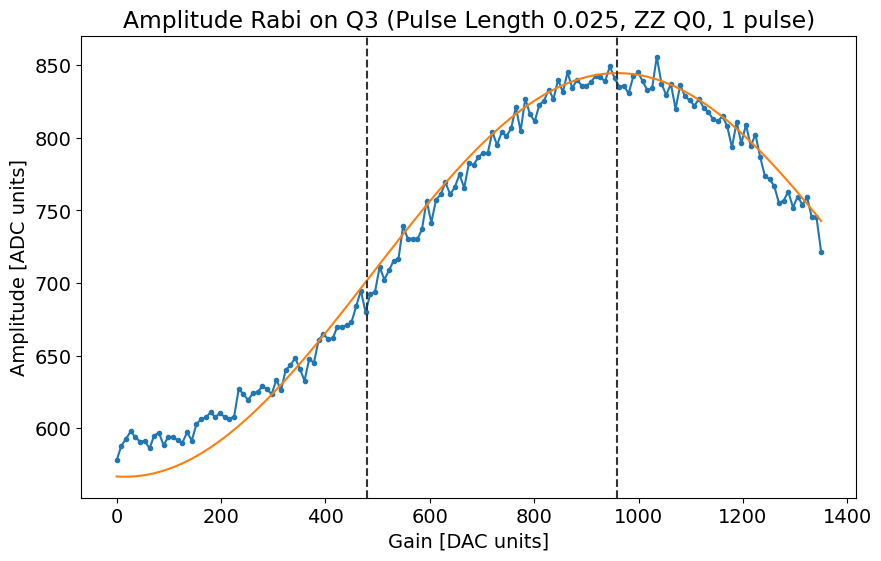

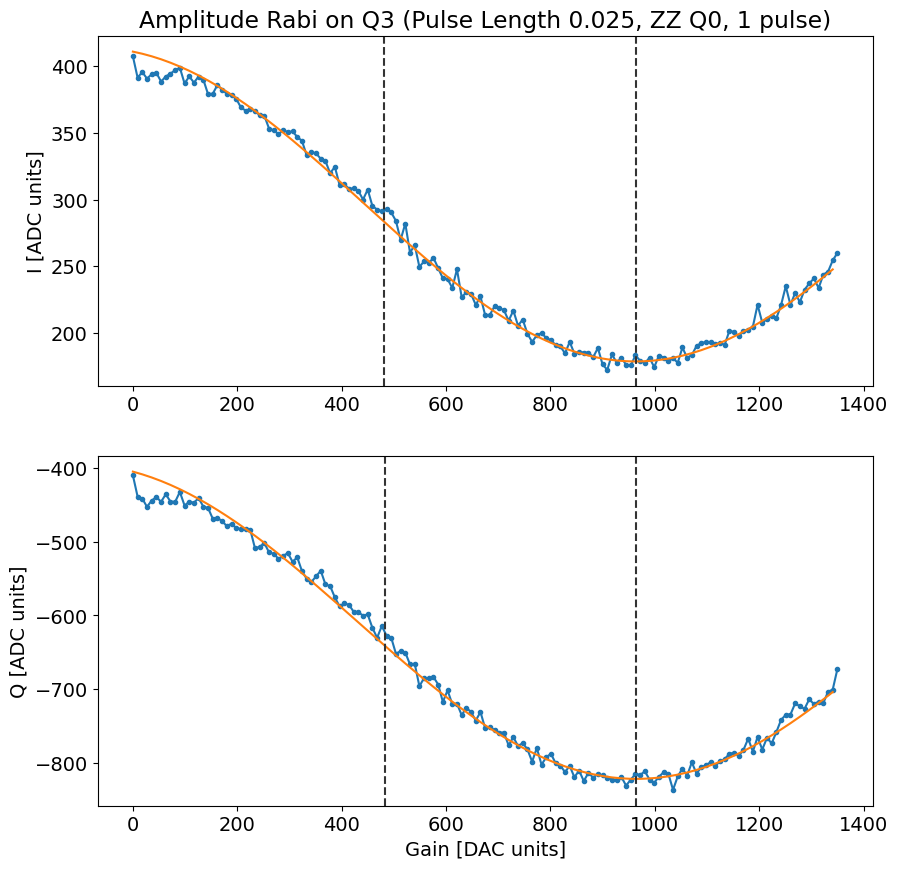

updated pi_gain round 2 963
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 81.75333333333333 	 angle (deg): 123.50160601256721 	 threshold ge: 335.3411856563031


  0%|          | 0/20 [00:00<?, ?it/s]

fitparams [None, 0.017453292519943295]
From amps: adjust amplitude to 963 / 0.9982686147417337 = 964.6702157907087


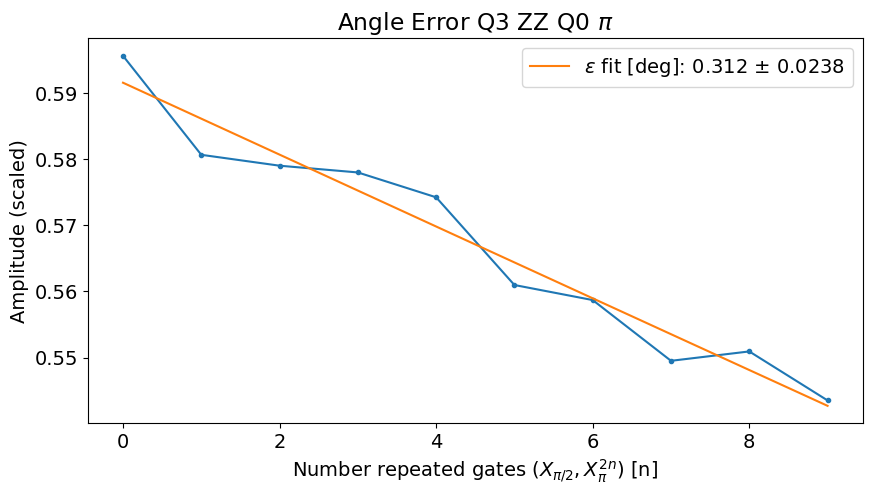

From avgi: adjust amplitude to 963 / 0.9982674050852915 = 964.6713847355576

From avgq: adjust amplitude to 963 / 1.000002387614378 = 962.9977007328438


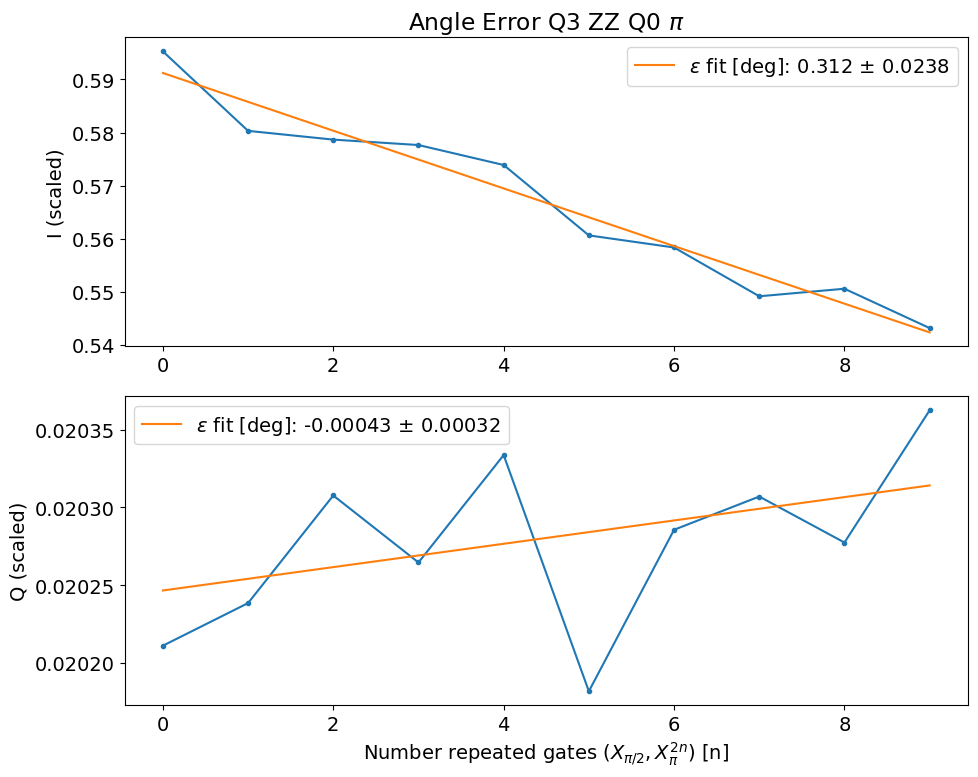

best 1 0.0400345926160381
updated pi_gain from error amplification 965





In [19]:
try: save_data
except: assert False, 'you did not run the cell above!'

thresholds=None
angles=None
ge_avgs=None
counts_calib=None

num_qubits_sample = 4

# for qTest in range(4):
    # for qZZ in range(4):
for qTest in [2, 3]:
    for qZZ in [0]:
        # if 1 not in [qZZ, qTest]: continue
        # if not (qZZ == 0 and qTest == 1): continue
        # if 0 not in [qZZ, qTest]: continue
        # if 0 not in [qZZ, qTest] and 3 not in [qZZ, qTest]: continue
        if qZZ == qTest: continue
        calib_index = qTest*num_qubits_sample + qZZ

        print(f"######### BEGINNING QUBIT {qTest} WITH ZZ FROM {qZZ} #########")

        # ----- Default values ----- #
        pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qTest, qZZ]
        pi_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qTest, qZZ]
        pi_freq = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))[qTest, qZZ]
        print('initial pi_len', pi_len)
        print('initial pi_gain', pi_gain)
        print('initial pi_freq', pi_freq)
        override = False

        # For each experiment, update the relevant local variable pi_x, update the yaml and pass it to the next function, update the results for the relevant variable


        # ----- Length Rabi ----- #
        if do_length_rabi or override:
            pi_len = run_length_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            # yaml_cfg.device.qubit.pulses.pi_ge.sigma[calib_index] = pi_len
            # print('updated pi_len', pi_len)
            # results['pi_ge_sigma'][calib_index] = pi_len
        override = False

        # ----- Amp Rabi ----- #
        # if qTest != 1: override = True
        if do_amp_rabi and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            yaml_cfg.device.qubit.pulses.pi_ge.gain[calib_index] = pi_gain
            print('updated pi_gain', pi_gain)
            results['pi_ge_gain'][calib_index] = pi_gain
        override = False

        # ----- Ramsey ----- #
        # if 1 not in [qZZ, qTest]: override = True
        # if (qZZ == 1 and qTest == 0): override = True
        if do_ramsey and not override:
            pi_freq = run_ramsey(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            yaml_cfg.device.qubit.f_ge[calib_index] = pi_freq
            print('updated pi_freq', pi_freq)
            results['f_ge'][calib_index] = pi_freq
        override = False

        # ----- Amp Rabi Round 2 ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_amp_rabi_2 and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            yaml_cfg.device.qubit.pulses.pi_ge.gain[calib_index] = pi_gain
            print('updated pi_gain round 2', pi_gain)
            results['pi_ge_gain'][calib_index] = pi_gain
        override = False

        # ----- Error amplification ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_error_amp and not override:
            pi_gain = run_error_amp(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            yaml_cfg.device.qubit.pulses.pi_ge.gain[calib_index] = pi_gain
            print('updated pi_gain from error amplification', pi_gain)
            results['pi_ge_gain'][calib_index] = pi_gain
        override = False


        # ----- Update results ----- #
        results['pi_ge_gain'][calib_index] = pi_gain
        results['pi_ge_sigma'][calib_index] = pi_len
        results['f_ge'][calib_index] = pi_freq

        print("\n\n")

In [21]:
print("UPDATE MANUALLY IN CONFIG:")
print('f_ge:')
print(yaml_cfg.device.qubit.f_ge)
print(np.reshape(yaml_cfg.device.qubit.f_ge, (4,4)))
print()
print('pi_ge: sigma')
print(yaml_cfg.device.qubit.pulses.pi_ge.sigma)
print()
print('pi_ge: gain')
print(yaml_cfg.device.qubit.pulses.pi_ge.gain)
print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4)))
print()

UPDATE MANUALLY IN CONFIG:
f_ge:
[4110.428247950795, 4105.038816552946, 4110.198576889643, 4109.933722963169, 3442.8436398119666, 3448.2234633901926, 3447.122665677232, 3446.8985639748066, 4762.060705219546, 4761.098043820929, 4762.201572322125, 4761.678033261405, 4381.145526567869, 4380.365504198304, 4381.142621732222, 4381.679544300405]
[[4110.42824795 4105.03881655 4110.19857689 4109.93372296]
 [3442.84363981 3448.22346339 3447.12266568 3446.89856397]
 [4762.06070522 4761.09804382 4762.20157232 4761.67803326]
 [4381.14552657 4380.3655042  4381.14262173 4381.6795443 ]]

pi_ge: sigma
[0.02, 0.02, 0.02, 0.02, 0.025, 0.025, 0.025, 0.025, 0.015, 0.015, 0.015, 0.015, 0.025, 0.025, 0.025, 0.025]

pi_ge: gain
[1854, 1984, 0, 0, 2834, 2631, 3310, 3132, 14489, 14379, 14389, 0, 965, 965, 0, 963]
[[ 1854  1984     0     0]
 [ 2834  2631  3310  3132]
 [14489 14379 14389     0]
 [  965   965     0   963]]



first update the config. then also update the ZZ matrix using the better calibrated values

In [170]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# EF with ZZ shifts

### Pulse probe EF with ZZ

In [95]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

qTest 3 qZZ 1
Running pulse probe EF on Q3 with ZZ Q1


  0%|          | 0/8 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4207.360913764545, HWHM 1.2646940452173276
Found peak in I at [MHz] 4207.388145651236, HWHM 1.37922515941732
Found peak in Q at [MHz] 4207.411146891188, HWHM 1.3748061494891133


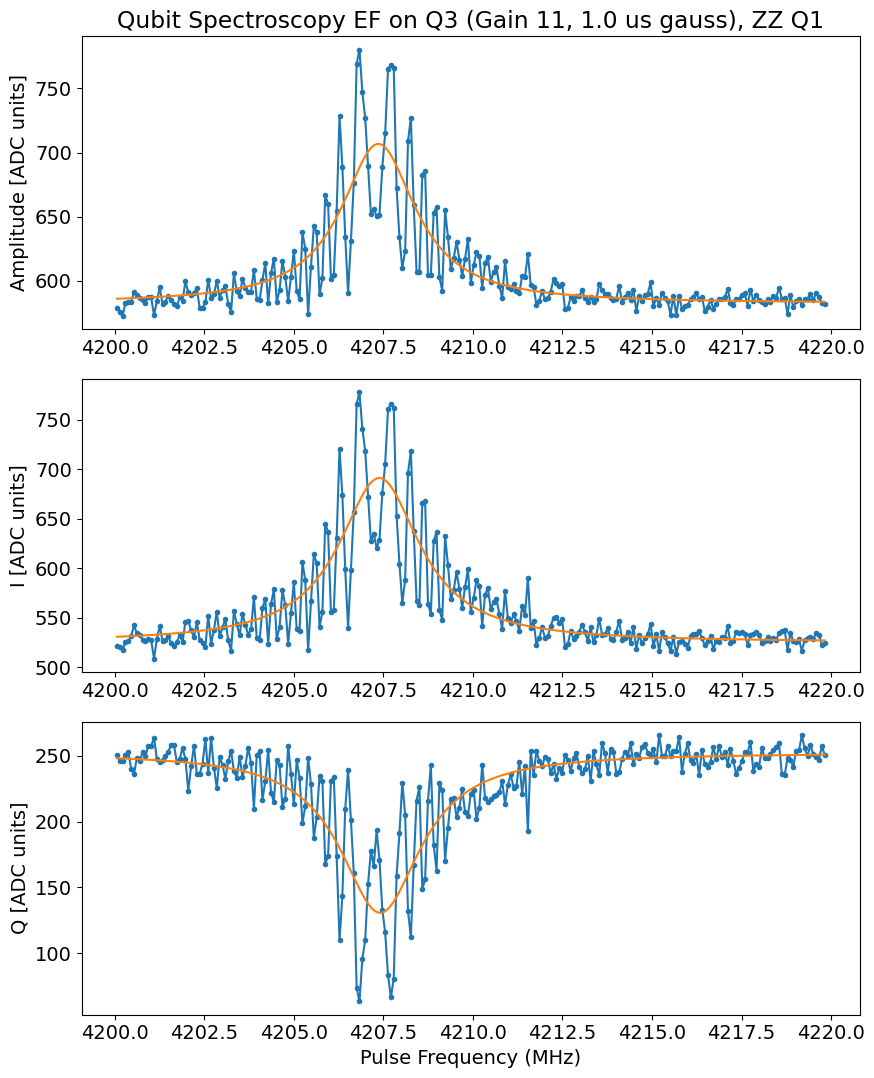

best 1 0.033113103229511935
Fit Q3 frequency with ZZ shift [MHz]: 4207.388145651236
Q3 shift due to Q1 in e [MHz]: -2.592995093317768


In [108]:
# for qTest in [2, 3]:
for qTest in [3]:
    # for qZZ in [0, 1]:
    for qZZ in [1]:
        # if not (qZZ == 0 and qTest == 1): continue
        # if 0 not in [qZZ, qTest]: continue
        # if 0 not in [qZZ, qTest] and 3 not in [qZZ, qTest]: continue

        if qZZ == qTest: continue

        # if qZZ == 0 and qTest != 3: continue
        print('qTest', qTest, 'qZZ', qZZ)

        qZZspec = meas.PulseProbeSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_spectroscopy_qubit{qTest}{qZZ}",
            config_file=config_path,
        )
        
        span = 20
        npts = 251
        
        qZZspec.cfg.expt = dict(
            start=np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))[qTest, qTest]-span/2, # [MHz]
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=8, # Number of start to finish sweeps to average over
            length=1.0, # qubit 0 probe constant pulse length [us]
            gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qTest, qTest]/60), # Qubit pulse gain
            pulse_type='gauss',
            qTest=qTest,
            qZZ=qZZ,
            checkEF=True,
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qTest} due to Q{qZZ} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)

        yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
        yaml_cfg.device.qubit.f_ef[qTest, qZZ] = qZZspec_fit[2]

        print(f'Fit Q{qTest} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qTest} shift due to Q{qZZ} in e [MHz]: {yaml_cfg.device.qubit.f_ef[qTest, qZZ] - yaml_cfg.device.qubit.f_ef[qTest, qTest]}')

        yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()

Optional: update manual config now, or just keep running the T2R calibration cell using the already updated yaml_cfg variable

In [109]:
ZZshifts_ef = np.zeros((4,4))
reshaped_f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
for row in range(4):
    for col in range(4):
        if row == col: continue
        if reshaped_f_ef[row, col] == 0:
            reshaped_f_ef[row, col] = reshaped_f_ef[row, row]

for row in range(4):
    ZZshifts_ef[row,:] = reshaped_f_ef[row,:] - reshaped_f_ef[row,row]
print('ZZ_efs:')
print(ZZshifts_ef)
# print(ZZshifts_ef.flatten().tolist())

print()
print(f'New f_ef\n', np.reshape(yaml_cfg.device.qubit.f_ef, (4,4)))

print()
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_ef:')
print(yaml_cfg.device.qubit.f_ef)


ZZ_efs:
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.48193065 -1.90362189  0.          0.        ]
 [ 1.36300421 -2.59299509  0.          0.        ]]

New f_ef
 [[3884.3737934     0.            0.            0.        ]
 [   0.         3347.76178906    0.            0.        ]
 [4571.90564823 4570.48395699 4572.38757889    0.        ]
 [4211.34414496 4207.38814565    0.         4209.98114074]]

UPDATE MANUALLY IN CONFIG:
f_ef:
[3884.3737933985267, 0.0, 0.0, 0.0, 0.0, 3347.761789059698, 0.0, 0.0, 4571.9056482340775, 4570.483956991979, 4572.387578885567, 0.0, 4211.344144956145, 4207.388145651236, 0.0, 4209.981140744554]


## Fine EF with ZZ calibrations

In [53]:
save_data = False
saved_files = []

In [54]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [55]:
# test_pi_half = False
# divide_len = True
test_pi_half = True
divide_len = False # for RB

do_length_rabi = do_amp_rabi = do_ramsey = do_amp_rabi_2 = do_error_amp = False

do_ramsey = True
do_amp_rabi_2 = True
do_error_amp = True

# put an override=True flag to force skipping certain qubits

######### BEGINNING QUBIT 3 EF WITH ZZ FROM 0 #########
initial pi_len 0.02
initial pi_gain 735
initial pi_freq 4211.727824098393
-------- Amp rabi --------
Running amp rabi EF on Q3 with ZZ Q0
Calibrating half pi gain (divide gain) when pi len is 0.02


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.054173789593133154
Pi gain from amps data [dac units]: 365
	Pi/2 gain from amps data [dac units]: 182
Pi gain from avgi data [dac units]: 365
	Pi/2 gain from avgi data [dac units]: 182
Pi gain from avgq data [dac units]: 365
	Pi/2 gain from avgq data [dac units]: 182


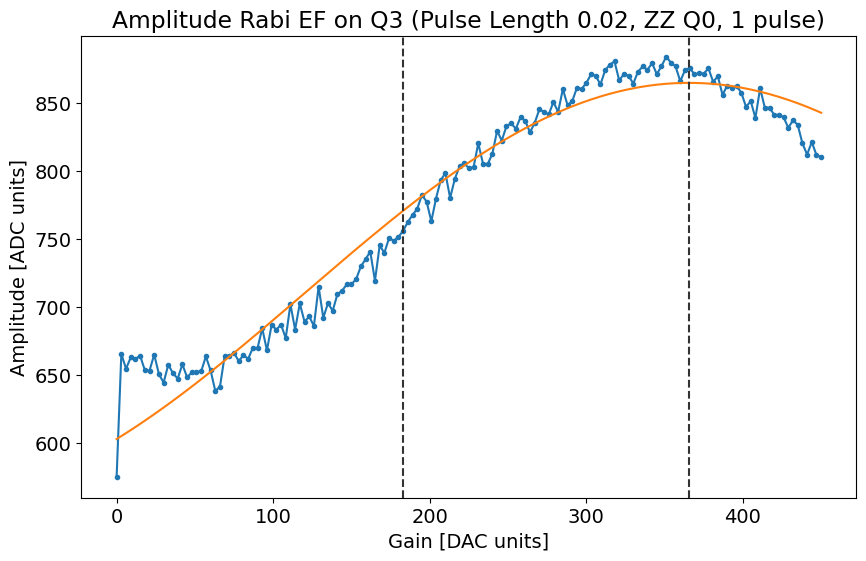

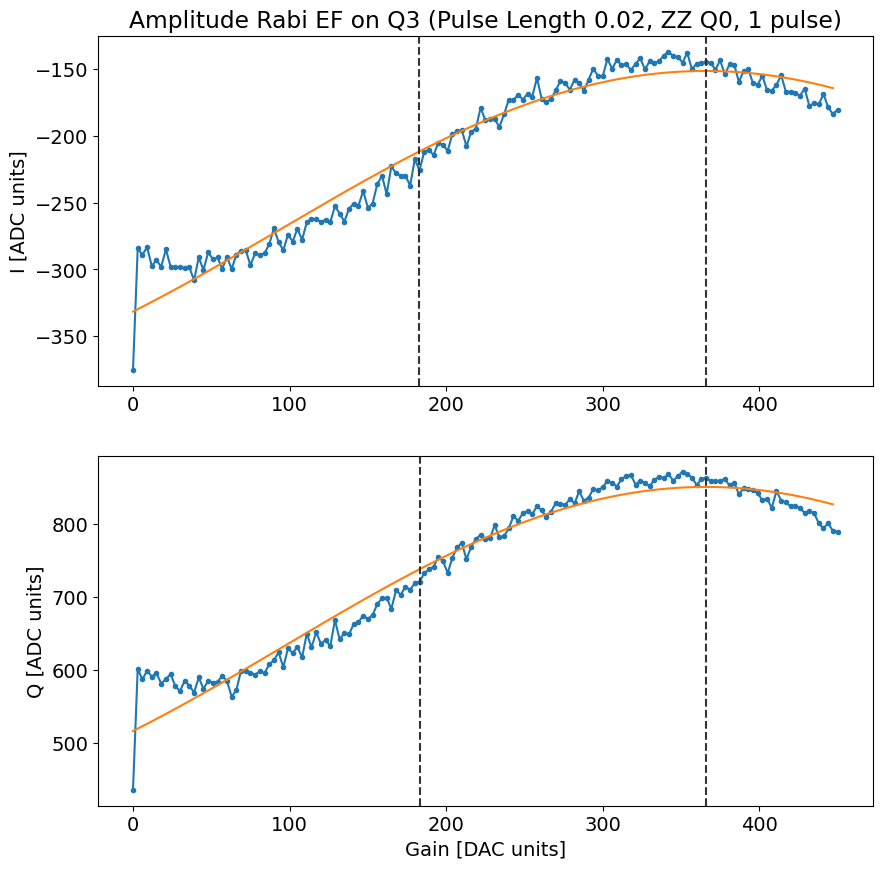

updated pi_gain round 2 365
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 80.25333333333333 	 angle (deg): -54.49421405474123 	 threshold ge: 364.48455213918817


  0%|          | 0/20 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py:384: RuntimeWarning: divide by zero encountered in divide
  avgi_rot /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]
s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py:385: RuntimeWarning: divide by zero encountered in divide
  avgi_err /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]


fitparams [None, 0.017453292519943295]
From amps: adjust amplitude to 365 / 1.0424295662991687 = 350.14356058205664


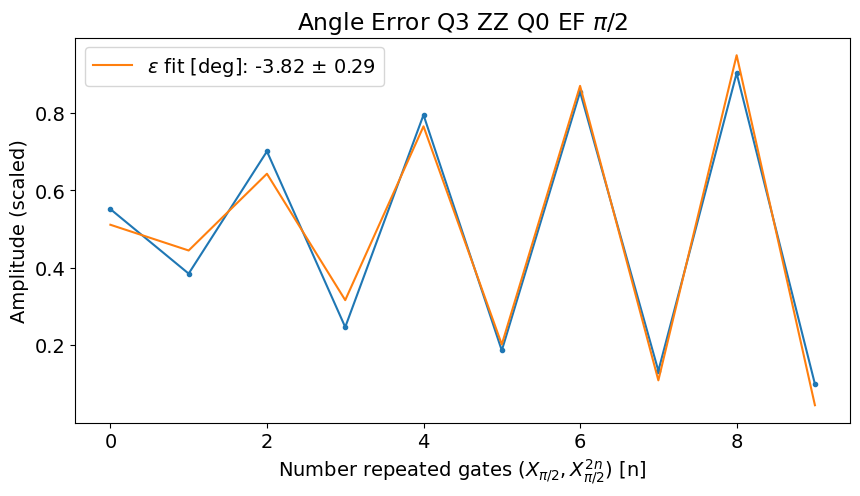

From avgi: adjust amplitude to 365 / 1.042524054742426 = 350.11182556375616

From avgq: adjust amplitude to 365 / 1.0000333193480415 = 364.9878388431667


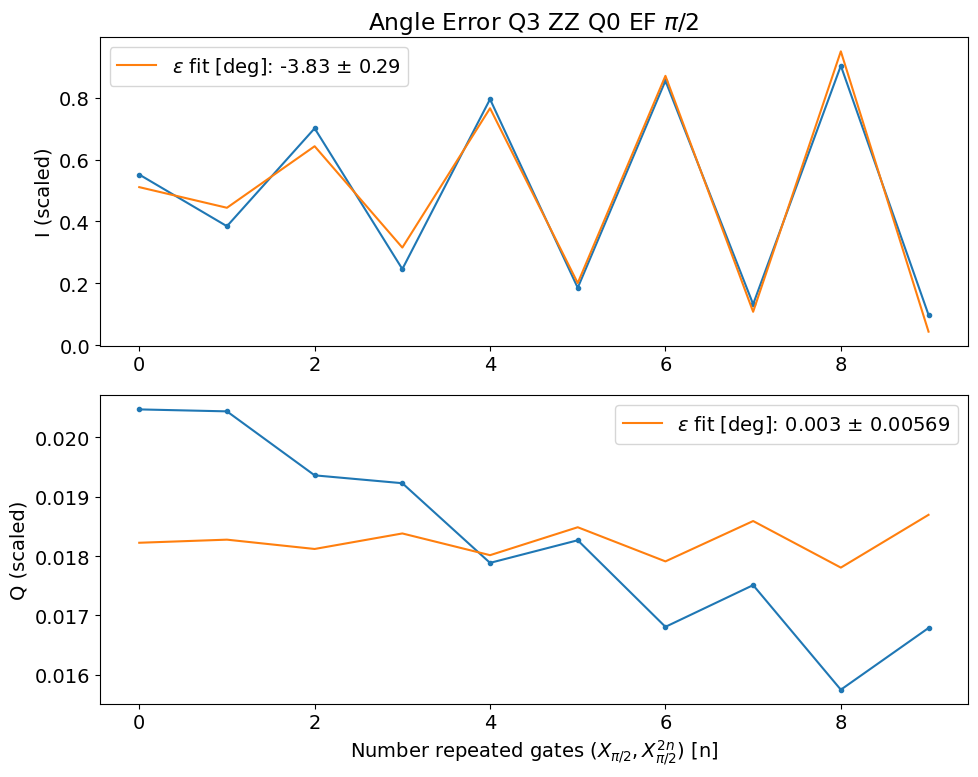

best 1 0.05355925483304264
updated pi_gain from error amplification 350





In [56]:
try: save_data
except: assert False, 'you did not run the cell above!'

thresholds=None
angles=None
ge_avgs=None
counts_calib=None

num_qubits_sample = 4

# for qTest in [2, 3]:
for qTest in [3]:
    # for qZZ in [0, 1]:
    # for qZZ in [1]:
    for qZZ in [0]:
        # if not (qZZ == 0 and qTest == 1): continue
        # if 0 not in [qZZ, qTest]: continue
        # if 0 not in [qZZ, qTest] and 3 not in [qZZ, qTest]: continue

        if qZZ == qTest: continue

        if qZZ == 0 and qTest != 3: continue

        calib_index = qTest*num_qubits_sample + qZZ

        print(f"######### BEGINNING QUBIT {qTest} EF WITH ZZ FROM {qZZ} #########")

        # ----- Default values ----- #
        pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qTest, qZZ]
        pi_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qTest, qZZ]
        pi_freq = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))[qTest, qZZ]
        print('initial pi_len', pi_len)
        print('initial pi_gain', pi_gain)
        print('initial pi_freq', pi_freq)
        override = False

        # For each experiment, update the relevant local variable pi_x, update the yaml and pass it to the next function


        # ----- Length Rabi ----- #
        if do_length_rabi or override:
            pi_len = run_length_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, test_pi_half=test_pi_half, divide_len=divide_len, save_data=save_data)
            # yaml_cfg.device.qubit.pulses.pi_ef.sigma[calib_index] = pi_len
            # print('updated pi_len', pi_len)
        override = False

        # ----- Amp Rabi ----- #
        # if qTest != 1: override = True
        if do_amp_rabi and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, test_pi_half=test_pi_half, divide_len=divide_len, save_data=save_data)
            if test_pi_half:
                if divide_len: yaml_cfg.device.qubit.pulses.pi_ef.half_gain[calib_index] = pi_gain
                else: yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[calib_index] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_ef.gain[calib_index] = pi_gain
            print('updated pi_gain', pi_gain)
        override = False

        # ----- Ramsey ----- #
        # if 1 not in [qZZ, qTest]: override = True
        # if (qZZ == 1 and qTest == 0): override = True
        if test_pi_half: override = True # ramsey not useful for pi half calibration
        if do_ramsey and not override:
            pi_freq = run_ramsey(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, save_data=save_data)
            yaml_cfg.device.qubit.f_ef[calib_index] = pi_freq
            print('updated pi_freq', pi_freq)
        override = False

        # ----- Amp Rabi Round 2 ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_amp_rabi_2 and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, test_pi_half=test_pi_half, divide_len=divide_len, save_data=save_data)
            if test_pi_half:
                if divide_len: yaml_cfg.device.qubit.pulses.pi_ef.half_gain[calib_index] = pi_gain
                else: yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[calib_index] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_ef.gain[calib_index] = pi_gain
            print('updated pi_gain round 2', pi_gain)
        override = False

        # ----- Error amplification ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_error_amp and not override:
            pi_gain = run_error_amp(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, test_pi_half=test_pi_half, divide_len=divide_len, save_data=save_data)
            if test_pi_half:
                if divide_len: yaml_cfg.device.qubit.pulses.pi_ef.half_gain[calib_index] = pi_gain
                else: yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[calib_index] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_ef.gain[calib_index] = pi_gain
            print('updated pi_gain from error amplification', pi_gain)
        override = False

        print("\n\n")

In [58]:
print("UPDATE MANUALLY IN CONFIG:")
print('f_ef:')
print(yaml_cfg.device.qubit.f_ef)
print('pi_ef: sigma')
print(yaml_cfg.device.qubit.pulses.pi_ef.sigma)

if test_pi_half:
    if divide_len:
        print('pi_ef: half_gain')
        print(yaml_cfg.device.qubit.pulses.pi_ef.half_gain)
        print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain, (4,4)))
    else:
        print('pi_ef: half_gain_pi_sigma')
        print(yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma)
        print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma, (4,4)))
else:
    print('pi_ef: gain')
    print(yaml_cfg.device.qubit.pulses.pi_ef.gain)
    print(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4)))

print()
ZZshifts_ef = np.zeros((4,4))
reshaped_f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
for row in range(4):
    for col in range(4):
        if row == col: continue
        if reshaped_f_ef[row, col] == 0:
            reshaped_f_ef[row, col] = reshaped_f_ef[row, row]

for row in range(4):
    ZZshifts_ef[row,:] = reshaped_f_ef[row,:] - reshaped_f_ef[row,row]
print('ZZ_efs:')
print(ZZshifts_ef)
# print(ZZshifts_ef.flatten().tolist())

print()
print(f'New f_ef\n', np.reshape(yaml_cfg.device.qubit.f_ef, (4,4)))

UPDATE MANUALLY IN CONFIG:
f_ef:
[3884.3737933985267, 0.0, 0.0, 0.0, 0.0, 3347.761789059698, 0.0, 0.0, 4571.9056482340775, 4570.482481434396, 4572.387578885567, 0.0, 4211.727824098393, 4207.262930371132, 0.0, 4209.981140744554]
pi_ef: sigma
[0.02, 0.02, 0.02, 0.02, 0.025, 0.025, 0.025, 0.025, 0.015, 0.015, 0.015, 0.015, 0.02, 0.02, 0.02, 0.02]
pi_ef: half_gain_pi_sigma
[673, 0, 0, 0, 0, 975, 0, 0, 0, 0, 5049, 0, 350, 0, 0, 337]
[[ 673    0    0    0]
 [   0  975    0    0]
 [   0    0 5049    0]
 [ 350    0    0  337]]

ZZ_efs:
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.48193065 -1.90509745  0.          0.        ]
 [ 1.74668335 -2.71821037  0.          0.        ]]

New f_ef
 [[3884.3737934     0.            0.            0.        ]
 [   0.         3347.76178906    0.            0.        ]
 [4571.90564823 4570.48248143 4572.38757889    0.        ]
 [4211.7278241  4207.26293037    0.         4209.98114074]]


# Get couplings and bare qubit and ef frequencies by optimization

In [121]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [123]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [124]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [125]:
# gs_arr = [g01, g12, g13, g02, g03, g23]
def gs_mat_from_gs_arr(gs_arr):
    gs_matrix = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1
    gs_matrix[0, 1] = gs_arr[0]
    gs_matrix[1, 2] = gs_arr[1]
    gs_matrix[1, 3] = gs_arr[2]
    gs_matrix[0, 2] = gs_arr[3]
    gs_matrix[0, 3] = gs_arr[4]
    gs_matrix[2, 3] = gs_arr[5]
    gs_matrix += gs_matrix.transpose()
    return gs_matrix

In [126]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_fq_alpha_diff(fges_alphas_gs, *args):
    qubit_freqs, alphas_meas, ZZ_matrix = args # measured values
    fges = fges_alphas_gs[:4] 
    alphas = fges_alphas_gs[4:8] 
    gs = fges_alphas_gs[8:]
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs_mat_from_gs_arr(gs),
        qubit_freqs=fges,
        alphas=alphas,
        cutoffs=[3, 3, 3, 3],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    error_ZZ = np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)
    # error_ZZ = np.sum(np.abs(1e3*(abs(ZZ_matrix) - abs(qram.get_ZZ_matrix())))**2)
    error_fge = 0
    error_alpha = 0
    gstate = 'gggg'
    for i in range(4):
        estate = gstate[:i] + 'e' + gstate[i+1:]
        error_fge += np.sum(np.abs(1e3*(qram.get_base_wd(gstate, estate)/2/np.pi - qubit_freqs[i])**2))
        fstate = gstate[:i] + 'f' + gstate[i+1:]
        error_alpha += np.sum(np.abs(1e3*(qram.get_base_wd(estate, fstate)/2/np.pi - (qubit_freqs[i] + alphas_meas[i]))**2))
    return error_ZZ + error_fge + error_alpha

In [128]:
gs_guess_MHz = np.array([50, 50, 50, 5, 5, 5])
qubit_freqs_MHz = np.array(np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))).diagonal()
ef_freqs_MHz = np.array(np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))).diagonal()
alphas_MHz = ef_freqs_MHz - qubit_freqs_MHz
print('qubit_freqs', qubit_freqs_MHz)
print('ef_freqs', ef_freqs_MHz)
print('alphas', alphas_MHz)

ZZshifts_MHz = np.zeros((4,4))
reshaped_f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
for row in range(4):
    ZZshifts_MHz[row,:] = reshaped_f_ge[row,:] - reshaped_f_ge[row,row]

delta_fq = 25e-3 # GHz away from measured
delta_alpha = 10e-3 # GHz away from measured
delta_g = 15e-3 # GHz away from measured
# x0 = np.array([*qubit_freqs_MHz, 50, 50, 50, 5, 5, 5])
x0 = np.array([*qubit_freqs_MHz, *alphas_MHz, *gs_guess_MHz])
print('x0', x0)
bounds_fq = [(1e-3*fq_MHz - delta_fq, 1e-3*fq_MHz + delta_fq) for fq_MHz in qubit_freqs_MHz]
bounds_alpha = [(1e-3*alpha_MHz - delta_alpha, 1e-3*alpha_MHz + delta_alpha) for alpha_MHz in alphas_MHz]
bounds_gs = [(np.max((0, 1e-3*g_MHz - delta_g)), 1e-3*g_MHz + delta_g) for g_MHz in gs_guess_MHz]
# bounds = [*bounds_fq, (10e-3, 100e-3), (10e-3, 100e-3), (10e-3, 100e-3), (1e-3, 50e-3), (1e-3, 50e-3), (1e-3, 50e-3)] # GHz
bounds = [*bounds_fq, *bounds_alpha, *bounds_gs] # GHz

result = minimize(ZZ_g_fq_alpha_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts_MHz), bounds=bounds , method='L-BFGS-B')
print(f'Success: {result.success}')

qubit_freqs [4110.42824795 3448.22346339 4762.20157232 4381.6795443 ]
ef_freqs [3884.3737934  3347.76178906 4572.38757889 4209.98114074]
alphas [-226.05445455 -100.46167433 -189.81399344 -171.69840356]
x0 [4110.42824795 3448.22346339 4762.20157232 4381.6795443  -226.05445455
 -100.46167433 -189.81399344 -171.69840356   50.           50.
   50.            5.            5.            5.        ]
Success: True


In [129]:
fges_alphas_gs_opt = result.x
fges_opt_MHz = fges_alphas_gs_opt[:4] * 1e3
alphas_opt_MHz = fges_alphas_gs_opt[4:8] * 1e3
gs_opt_MHz = fges_alphas_gs_opt[8:] * 1e3

qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=1e-3*gs_mat_from_gs_arr(gs_opt_MHz),
    qubit_freqs=1e-3*fges_opt_MHz,
    alphas=1e-3*alphas_opt_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured (coupled) qubits freqs [MHz]')
print(qubit_freqs_MHz)
print('Measured (coupled) ef freqs [MHz]')
print(ef_freqs_MHz)
print()

print('Optimized (uncoupled) qubit freqs [MHz]')
print(fges_opt_MHz)
print('Optimized (uncoupled) alphas [MHz]')
print(alphas_opt_MHz)

optimized_fges = []
optimized_fefs = []
gstate = 'gggg'
for i in range(4):
    estate = gstate[:i] + 'e' + gstate[i+1:]
    optimized_fges.append(1e3*(qram.get_base_wd(gstate, estate)/2/np.pi))
    fstate = gstate[:i] + 'f' + gstate[i+1:]
    optimized_fefs.append(1e3*(qram.get_base_wd(estate, fstate)/2/np.pi))
print('Optimized (coupled) qubit freqs [MHz]')
print(optimized_fges)
print('Optimized (coupled) qubit ef freqs [MHz]')
print(optimized_fefs)
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]')
print('gs: [', end='')
print(*(gs_opt_MHz), sep=', ', end=']\n')
print()
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print('Measured ZZ matrix [MHz]')
print(ZZshifts_MHz)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print()
print(f'Optimization error: {ZZ_g_fq_alpha_diff(fges_alphas_gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts_MHz)}')

Measured (coupled) qubits freqs [MHz]
[4110.42824795 3448.22346339 4762.20157232 4381.6795443 ]
Measured (coupled) ef freqs [MHz]
[3884.3737934  3347.76178906 4572.38757889 4209.98114074]

Optimized (uncoupled) qubit freqs [MHz]
[4106.48521728 3456.71075434 4759.62153635 4379.71394274]
Optimized (uncoupled) alphas [MHz]
[-230.51350904 -102.27192735 -191.1149695  -173.14733119]
Optimized (coupled) qubit freqs [MHz]
[4110.427194771979, 3448.222910840087, 4762.201055544314, 4381.6802895449055]
Optimized (coupled) qubit ef freqs [MHz]
[3884.3741569944546, 3347.7623161951833, 4572.386889357652, 4209.982277430425]
Optimized g01, g12, g13, g02, g03, g23 [MHz]
gs: [52.57507833782463, 54.866721187108546, 43.95968814293826, 5.879398801080635, 2.4374943527466506, 6.230310161957165]

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.3894314  -0.22967106 -0.49452499]
 [-5.379823